In [70]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et
import os
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
import time

In [2]:
def iou_cal(box1, box2):
'''
Inputs: file_name as a string
Outputs: GT boxes coordinates and the image file
This method first obtain the absolute path of the image file and its corresponding XML file, then read the image with cv2.imread() and parse the XML file with findall function in XML package to get the coordinates of the Ground Truth.
'''
    top_bound = max(box1[1], box2[1])
    bottom_bound = min(box1[3], box2[3])
    left_bound = max(box1[0], box2[0])
    right_bound = min(box1[2], box2[2])
    total_area = sum([(box[2] - box[0])*(box[3] - box[1]) for box in [box1, box2]])
    
    if left_bound >= right_bound or top_bound >= bottom_bound:
        return 0
    else:
        intersect = (right_bound - left_bound) * (bottom_bound - top_bound)
        return intersect / (total_area - intersect)

In [3]:
def file_parse(file_name):
'''
Inputs: coordinates of box1 and box2 with coordinate order (x1,y1,x2,y2) respectively
Outputs: The intersection area of two boxes
'''
    boxes = []
    current_path = os.path.abspath("./HW2_Data/Annotations/")
    xml_path = os.path.join(current_path, file_name+'.xml')
    tree = et.parse(xml_path)
    root = tree.getroot()
    for objects in root.findall('object'):
        for box in objects.findall('bndbox'):
            boxes.append([int(box.find('xmin').text), int(box.find('ymin').text), 
                         int(box.find('xmax').text), int(box.find('ymax').text)])
    
    current_path = os.path.abspath("./HW2_Data/JPEGImages/")
    jpg_path = os.path.join(current_path, file_name+'.jpg')
    img = cv2.imread(jpg_path)
    return boxes, img

In [118]:
def gt_compute(gt_list, proposal_list, img, thres, print_limit):
'''
Inputs: Ground Truth and proposal coordinate list, img file, IoU threshold and number of the 				 boxes display on the plot
Outputs: The image with Ground Truth boxes and proposal boxes, positive counts for both 				     proposal boxes and Grount Truth boxes.
The boxes are displayed with the method cv2.rectangle.
'''
    proposal_list = proposal_list[:print_limit]
    positive_proposal = set()
    positive_gt = set()
    for proposal in proposal_list:
        cv2.rectangle(img, (proposal[0], proposal[1]), (proposal[2], proposal[3]), [200,200,200], 1)
    for gt in gt_list:
        cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), [255,0,0], 2)
        for proposal in proposal_list:
            if iou_cal(gt, proposal)>=thres:
                cv2.rectangle(img, (proposal[0], proposal[1]), (proposal[2], proposal[3]), [0,235,50], 2)
                cv2.rectangle(img, (gt[0], gt[1]), (gt[2], gt[3]), [255,185,0], 2)
                positive_proposal.add(tuple(proposal.tolist()))
                positive_gt.add(tuple(gt))
    return img, len(positive_proposal), len(positive_gt)

In [20]:
def ss_seg(img, strategy, limit):
'''
Imputs: Image file, search strategy and the length limitation for generating the proposals
Outputs: The coordinate of proposal boxes. The order of output boxes are (x1,y1,x2,y2)
'''
    if strategy == 'color':
        ss_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyColor()
    elif strategy == 'texture':
        ss_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyTexture()
    elif strategy == 'multiple':
        ss_strategy = cv2.ximgproc.segmentation.createSelectiveSearchSegmentationStrategyMultiple()
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.addStrategy(ss_strategy)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchQuality()
#     ss.switchToSelectiveSearchFast()
    boxes = ss.process()
    boxes[:,2], boxes[:,3] = boxes[:,0]+boxes[:,2], boxes[:,1]+boxes[:,3]
    # switch the order from x,y,w,h to x0, y0, x1, y1
    return boxes[:limit]

In [125]:
def eb_seg(img, alpha, beta, limit):
'''
Imputs: Image file, alpha and beta values for Edge Boxes search strategy and the length 		        			  limitation for generating the proposals
Outputs: The coordinate of proposal boxes and its corresponding scores. The order of output 				 boxes are (x1,y1,x2,y2)
'''
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    edges = edge_detection.detectEdges(np.float32(rgb_img) / 255)
    orimap = edge_detection.computeOrientation(edges)
    edges = edge_detection.edgesNms(edges, orimap)
    
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setAlpha(alpha)
    edge_boxes.setBeta(beta)
    edge_boxes.setMaxBoxes(limit)
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)
    boxes[:,2], boxes[:,3] = boxes[:,0]+boxes[:,2], boxes[:,1]+boxes[:,3]
    return boxes, scores

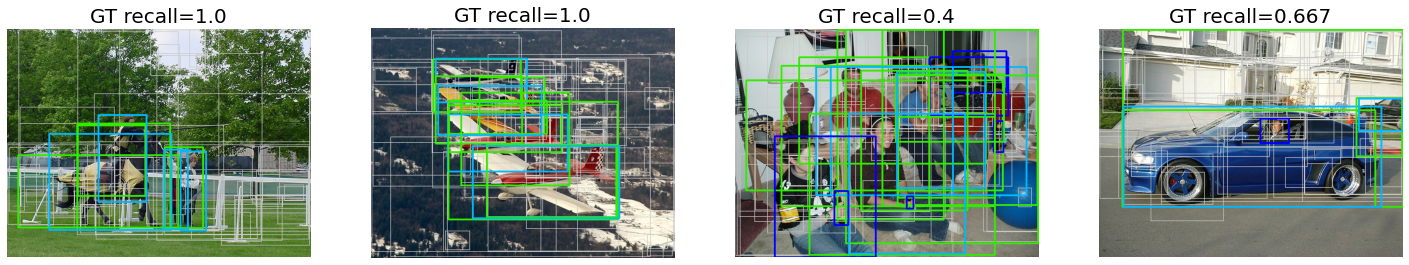

The algorithm runs in 4.39 sec
The sum of IoU is : 3.0666666666666664


In [129]:
file_list = {'000009', '000220', '002129', '006919'}
strategy = 'color'
limit = 100
print_limit = 100
thres = 0.5
alpha = 0.5
beta = 0.5

if __name__ == '__main__':
    index = 0
    f, grp = plt.subplots(1, 4)
    start_time = time.time()
    count = []
    for file_name in file_list:
        gt_list, img = file_parse(file_name)
        img_copy = img.copy()
        
#         ss_proposal = ss_seg(img_copy, strategy, limit)
#         ss_img, ss_p_positive, ss_gt_positive = gt_compute(gt_list, ss_proposal, img_copy, thres, print_limit)
#         ss_img = cv2.cvtColor(ss_img, cv2.COLOR_BGR2RGB)
#         grp[index].imshow(ss_img)
#         grp[index].set_title('GT recall={}'.format(round(ss_gt_positive/len(gt_list),3)), fontsize=20)
#         grp[index].axis('off')
#         count.append(ss_gt_positive/len(gt_list))
        
        eb_proposal, eb_scores = eb_seg(img_copy, alpha, beta, limit)
        eb_img, eb_p_positive, eb_gt_positive = gt_compute(gt_list, eb_proposal, img_copy, thres, print_limit)
        eb_img = cv2.cvtColor(eb_img, cv2.COLOR_BGR2RGB)
        grp[index].imshow(eb_img)
        grp[index].set_title('GT recall={}'.format(round(eb_gt_positive/len(gt_list),3)), fontsize=20)
        grp[index].axis('off')
        count.append(eb_gt_positive/len(gt_list))
        
        index += 1
    plt.show()
    end_time = time.time()
    print("The algorithm runs in {} sec".format(round(end_time-start_time, 2)))
    print("The sum of IoU is :", sum(count))